In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [2]:
# import libraries
import cv2
import sys
import os
import time
import gc
import numpy as np
import numpy.matlib
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sklearn as sk
import sklearn.decomposition
import skimage.draw
# import tensortools as tt
# import pywt
# import scaleogram as scg
import scipy
import scipy.signal
import pandas as pd

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

import multiprocessing
from multiprocessing import Pool

import imageio

import pywavesurfer.ws

import torch
import torch.cuda

# import mtaper_specgram
# import test_function

In [3]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

# import tensorly as tl
# import tensorly.decomposition
# import tensorly.random

In [4]:
# sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/face-rhythm/functions')

# import mtaper_specgram

In [5]:
# sys.path.insert(0, 'G:\My Drive\Research\Sabatini Lab Stuff - working\Code\PYTHON functions')
sys.path.insert(0, '/media/rich/Home_Linux_partition1/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON functions')
import getVideoDirectoryProperties

In [6]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

torch_env


In [7]:
%matplotlib notebook

In [8]:
### find version of openCV
# script currently works with v4.4.0
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print(f'OpenCV version: {major_ver}.{minor_ver}.{subminor_ver}')
# print(cv2.getBuildInformation())

### find version of pytorch
print(f'Pytorch version: {torch.__version__}')

## prep stuff
## find slash type of operating system

if sys.platform == 'linux':
    slash_type = '/'
    print('Autodetected operating system: Linux. Using "/" for directory slashes')
elif sys.platform == 'win32':
    slash_type = '\\'
    print(f'Autodetected operating system: Windows. Using "{slash_type}" for directory slashes')
elif sys.platform == 'darwin':
    slash_type = '/'
    print("What computer are you running this on? I haven't tested it on OSX or anything except windows and ubuntu.")
    print('Autodetected operating system: OSX. Using "/" for directory slashes')
    

OpenCV version: 4.4.0
Pytorch version: 1.7.0
Autodetected operating system: Linux. Using "/" for directory slashes


In [9]:
## == IMPORT DATA ==

## import S2p data

dir_s2p = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210113/suite2p/plane0'

F = np.load(f'{dir_s2p}{slash_type}F.npy')
Fneu = np.load(f'{dir_s2p}{slash_type}Fneu.npy')
iscell = np.load(f'{dir_s2p}{slash_type}iscell.npy')
ops = np.load(f'{dir_s2p}{slash_type}ops.npy', allow_pickle=True)
spks = np.load(f'{dir_s2p}{slash_type}spks.npy')
stat = np.load(f'{dir_s2p}{slash_type}stat.npy', allow_pickle=True)

num_frames_S2p = F.shape[1]

In [10]:
# ## == IMPORT DATA ==

# ## Import ROI Classifier data

# dir_ROIClassifier = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210121/'

# IsCell_ROIClassifier = np.load(f'{dir_ROIClassifier}{slash_type}IsCell_ROIClassifier.npy')
# ROI_Classifier_manual_selection_vars = np.load(f'{dir_ROIClassifier}{slash_type}manual_selection_vars.npy', allow_pickle=True)


<IPython.core.display.Javascript object>


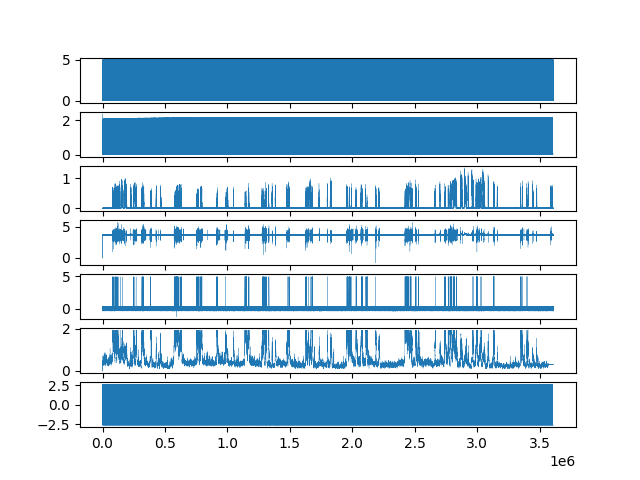

In [10]:
### import wavesurfer data

dir_ws = r'/media/rich/bigSSD RH/res2p/wavesurfer data/round 4 experiments/mouse 11.5/20210113'
fileName_ws = 'exp_0001.h5'

data_as_dict = pywavesurfer.ws.loadDataFile(filename=f'{dir_ws}{slash_type}{fileName_ws}', format_string='double' )
ws_data = data_as_dict[f'{list(data_as_dict.keys())[1]}']['analogScans']

fig = plt.figure()
for ii in range(ws_data.shape[0]):
    subplot_size = int(str(ws_data.shape[0]) + str(1) + str(ii+1))
    ax1 = fig.add_subplot(subplot_size)
    plt.plot(ws_data[ii,:] , linewidth=0.2)

In [12]:
### import camera GPIO pin signals
from concurrent import futures
import tqdm
from tqdm import trange

dir_cameraVidsForGPIO = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210114/cam1/exp'
fileName_prefix_cameraVidsForGPIO = 'fc2_save_2021-01-14-201020-'
fileName_suffix_cameraVidsForGPIO = '.avi'

tic = time.time()

path_vid_allFiles , vid_height , vid_width , numFrames_total_rough , Fs_camera = getVideoDirectoryProperties.getVideoDirectoryProperties(
        1 , dir_cameraVidsForGPIO , fileName_prefix_cameraVidsForGPIO , fileName_suffix_cameraVidsForGPIO , [] , slash_type , 1)

number of videos: 74
number of frames in FIRST video (roughly):  5970
number of frames in ALL videos (roughly):   438996
Sampling rate pulled from video file metadata:   120.005 frames per second

 ['/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210114/cam1/exp/fc2_save_2021-01-14-201020-0000.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210114/cam1/exp/fc2_save_2021-01-14-201020-0001.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210114/cam1/exp/fc2_save_2021-01-14-201020-0002.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210114/cam1/exp/fc2_save_2021-01-14-201020-0003.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210114/cam1/exp/fc2_save_2021-01-14-201020-0004.avi'
 '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210114/cam1/exp/fc2_save_2021-01-14-201020-0005.avi'
 '/media/rich/bigSSD RH/res2p/Came

{'plugin': 'ffmpeg', 'nframes': inf, 'ffmpeg_version': '4.2.2-static https://johnvansickle.com/ffmpeg/ built with gcc 8 (Debian 8.3.0-6)', 'codec': 'mjpeg', 'pix_fmt': 'yuvj444p(pc', 'fps': 120.0, 'source_size': (608, 364), 'size': (608, 364), 'duration': 49.75}
FINISHED vid #: 0
FINISHED vid #: 14
FINISHED vid #: 4
FINISHED vid #: 10
FINISHED vid #: 11
FINISHED vid #: 9
FINISHED vid #: 2
FINISHED vid #: 15
FINISHED vid #: 3
FINISHED vid #: 13
FINISHED vid #: 12
FINISHED vid #: 1
FINISHED vid #: 7
FINISHED vid #: 8
FINISHED vid #: 5
FINISHED vid #: 6
FINISHED vid #: 25
FINISHED vid #: 19
FINISHED vid #: 35
FINISHED vid #: 33
FINISHED vid #: 22
FINISHED vid #: 28
FINISHED vid #: 18
FINISHED vid #: 24
FINISHED vid #: 31FINISHED vid #: 23

FINISHED vid #: 32
FINISHED vid #: 20
FINISHED vid #: 27
FINISHED vid #: 17
FINISHED vid #: 29
FINISHED vid #: 16
FINISHED vid #: 21
FINISHED vid #: 34FINISHED vid #: 30

FINISHED vid #: 26
FINISHED vid #: 36
FINISHED vid #: 37
FINISHED vid #: 38
FINISH

<IPython.core.display.Javascript object>


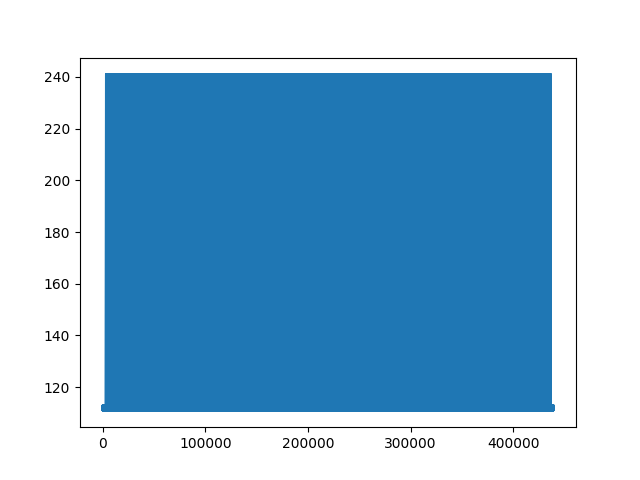

In [13]:
vid = imageio.get_reader(path_vid_allFiles[0],  'ffmpeg')

metadata = vid.get_meta_data()
print(metadata)

def get_pixels_topLeft_chunk(iter_vid):

    vid = imageio.get_reader(path_vid_allFiles[iter_vid],  'ffmpeg')

    metadata = vid.get_meta_data()
    upper_limit_on_number_of_frames = np.uint64((Fs_camera * metadata['duration'])*1.1)
    num_of_topLeft_pixels_to_extract = 16
    pixels_topLeft_chunk = np.ones((upper_limit_on_number_of_frames , num_of_topLeft_pixels_to_extract)) * np.nan

    for iter, im in enumerate(vid):
        pixels_topLeft_chunk[iter , :] = im[0,0:num_of_topLeft_pixels_to_extract,0].reshape((1,num_of_topLeft_pixels_to_extract))
        
#         new_frame_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)  # convert to grayscale
#         cv2.imshow('test',new_frame_gray)
#         cv2.waitKey(1)
#         k = cv2.waitKey(1) & 0xff
#         if k == 27 : break
                
    pixels_topLeft_chunk = pixels_topLeft_chunk[np.isnan(pixels_topLeft_chunk[:,0])==0 , :]


    print(f'FINISHED vid #: {iter_vid}')

    return pixels_topLeft_chunk

executer = futures.ThreadPoolExecutor(max_workers = multiprocessing.cpu_count())
pixels_topLeft_chunk_list = list(executer.map(get_pixels_topLeft_chunk , list(np.arange(len(path_vid_allFiles)))))
executer.shutdown()

# p = Pool(multiprocessing.cpu_count())  # where the magic acutally happens
# pixels_topLeft_chunk_list = p.map(get_pixels_topLeft_chunk , list(np.arange(len(path_vid_allFiles))))
# 
# p.close()
# p.terminate()
# p.join()


len(pixels_topLeft_chunk_list)
for ii in range(len(pixels_topLeft_chunk_list)):
    if ii == 0:
        pixels_topLeft = pixels_topLeft_chunk_list[ii]
    else:
        pixels_topLeft = np.concatenate((pixels_topLeft , pixels_topLeft_chunk_list[ii]) , axis=0)
        
signal_GPIO = pixels_topLeft[:,4]

print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

plt.figure()
plt.plot(signal_GPIO)


# np.save(f'D:\\res2p\\Camera data\\round 4 experiments\\mouse 6.28\\20200815\\pixels_topLeft.npy' , pixels_topLeft)

In [11]:
### save signal_GPIO
dir_save = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210121/cam1/exp'
name_save = 'signal_GPIO'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , signal_GPIO)

NameError: name 'signal_GPIO' is not defined

In [12]:
### load signal_GPIO
dir_load = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210113/cam1/exp'
name_load = 'signal_GPIO'
path_load = f'{dir_load}{slash_type}{name_load}.npy'

signal_GPIO = np.load(path_load)

<IPython.core.display.Javascript object>


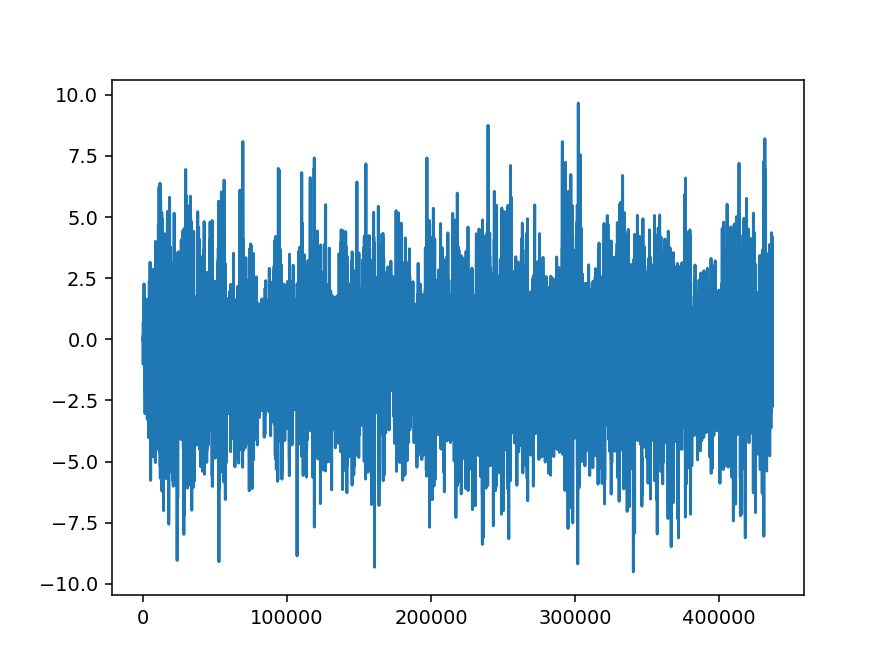

In [14]:
import pynwb
import matplotlib.pyplot as plt
import numpy as np
from face_rhythm.util import helpers, setup

config_filepath = '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210113/cam1/fixedVidIdx_run1/configs/config_fixedVidIdx_run1.yaml'
config = helpers.load_config(config_filepath)
# nwb_path = config['General']['sessions'][0]['nwb']
nwb_path        = '/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210113/cam1/fixedVidIdx_run1/data/exp.nwb'
# nwb_path = config['path_nwb']

with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()

    example_data = nwbfile.processing['Face Rhythm']['Optic Flow']['positions_convDR_meanSub'].data

    %matplotlib notebook
    plt.figure()
    plt.plot(example_data[0,0,:])

In [15]:
helpers.dump_nwb(nwb_path)

CQT
     Sxx_allPixels:    (1397, 35, 27309, 2)   ,  float32
     Sxx_allPixels_norm:    (1397, 35, 27309, 2)   ,  float32
     Sxx_allPixels_normFactor:    (27309, 2)   ,  float32
Optic Flow
     displacements:    (2483, 2, 436940)   ,  float64
     positions:    (2483, 2, 436940)   ,  float64
     positions_absolute:    (2483, 2, 436940)   ,  float64
     positions_convDR_absolute:    (1397, 2, 436940)   ,  float64
     positions_convDR_meanSub:    (1397, 2, 436940)   ,  float64
     positions_recursive:    (2483, 2, 436940)   ,  float64
TCA
     factors_spectral_points:    (2794, 8)   ,  float32
     factors_spectral_spectral:    (35, 8)   ,  float32
     factors_spectral_temporal:    (27309, 8)   ,  float32
     factors_spectral_temporal_interp:    (436939, 8)   ,  float64


<IPython.core.display.Javascript object>


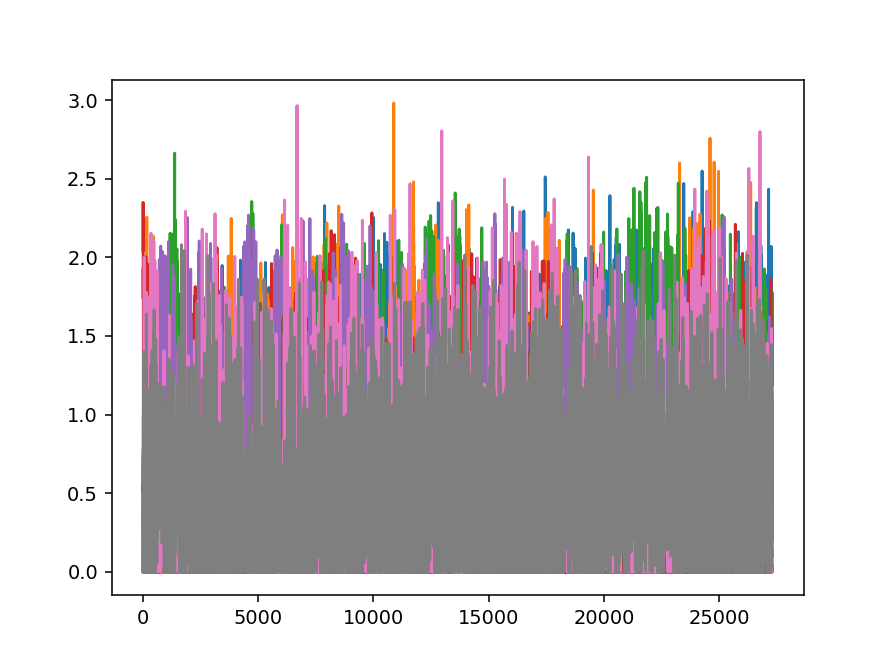

(27309, 8)


In [16]:
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()
    factors_temporal = np.array(nwbfile.processing['Face Rhythm']['TCA']['factors_spectral_temporal'].data)
    plt.figure()
    plt.plot(factors_temporal);
    print(factors_temporal.shape)

<IPython.core.display.Javascript object>


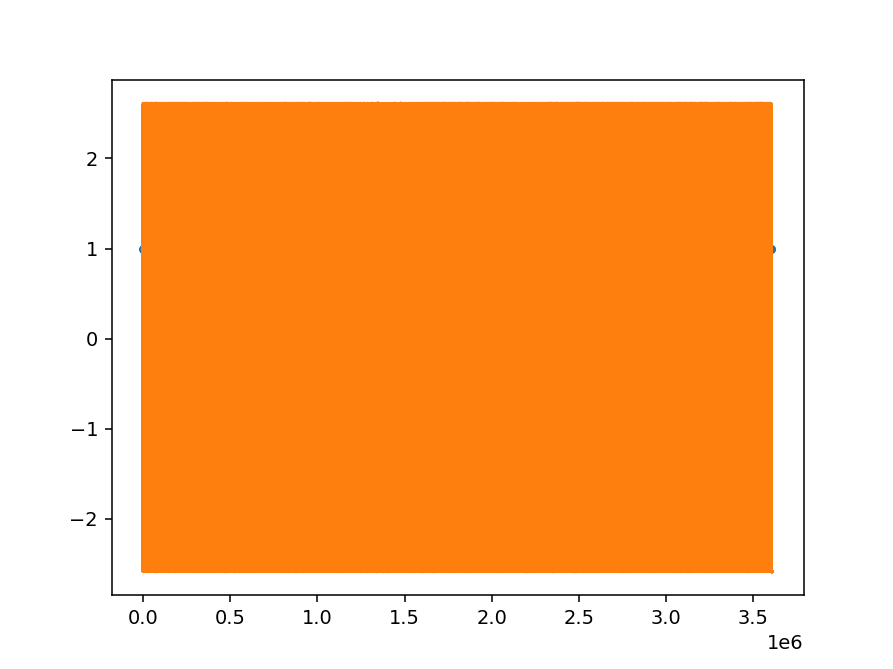

frames in scanimage movie = 108000
frames from ws galvo extraction movie = 108000
number of wavesurfer samples per imaging frame:  33.363787037037035
total elapsed time: 0.15 seconds


In [17]:
## == ALIGN DATA ==

# Get ws frame times in ws time. Everything should be aligned to ws frame times (S2pInd)

# Outputs:
# - ws_YGalvoFlybacks_bool_wsTime
# - ws_frameTimes_wsTime   ***

tic = time.time()
ws_YGalvoFlybacks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[6,:]) < -1)) > 0.5

ws_frameTimes_wsTime = np.array(np.where(ws_YGalvoFlybacks_bool_wsTime))[0,:]
ws_frameTimes_wsTime = ws_frameTimes_wsTime[0:num_frames_S2p+1]

plt.figure()
plt.plot(ws_frameTimes_wsTime,np.ones(len(ws_frameTimes_wsTime)),'.')
plt.plot(ws_data[6,:])
print(f'frames in scanimage movie = {num_frames_S2p}')
print(f'frames from ws galvo extraction movie = {ws_frameTimes_wsTime.shape[0]}')

ws_samples_per_S2p_frame_rough = (ws_frameTimes_wsTime[-1] - ws_frameTimes_wsTime[0]) / num_frames_S2p
print(f'number of wavesurfer samples per imaging frame:  {ws_samples_per_S2p_frame_rough}')
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


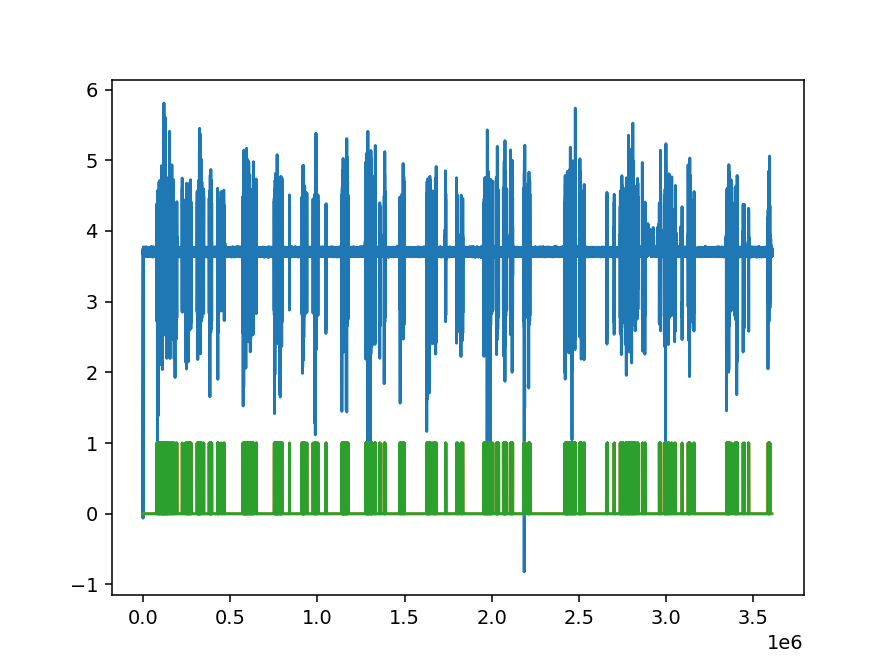

total elapsed time: 6.01 seconds


In [18]:
## Get lick times in S2p ind

# Outputs:
# - ws_licks_bool_wsTime
# - ws_licks_bool_S2pInd
# - ws_lickTimes_S2pInd   ***

tic = time.time()
ws_licks_bool_wsTime = np.diff(np.int8(np.diff(ws_data[3,:]) < -0.2)) > 0.5

ws_licks_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_licks_bool_S2pInd[frame_num] = sum(ws_licks_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_lickTimes_S2pInd = np.array(np.where(ws_licks_bool_S2pInd))

plt.figure()
plt.plot(ws_data[3,:])
plt.plot(ws_licks_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_licks_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


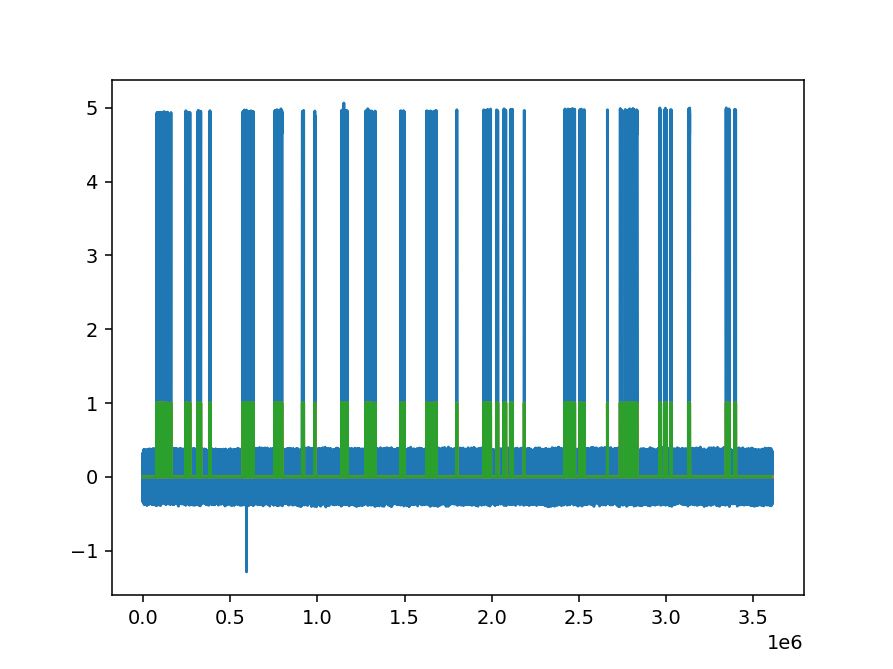

total elapsed time: 5.77 seconds


In [19]:
## Get reward delivery times in S2p ind

# Outputs:
# - ws_rewards_bool_wsTime
# - ws_rewards_bool_S2pInd
# - ws_rewardTimes_S2pInd   ***

tic = time.time()
ws_rewards_bool_wsTime = np.diff(np.int8(np.diff(ws_data[4,:]) > 1)) > 0.5


ws_rewards_bool_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_rewards_bool_S2pInd[frame_num] = sum(ws_rewards_bool_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]]) > 0.5

ws_rewardTimes_S2pInd = np.array(np.where(ws_rewards_bool_S2pInd))

plt.figure()
plt.plot(ws_data[4,:])
plt.plot(ws_rewards_bool_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_rewards_bool_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


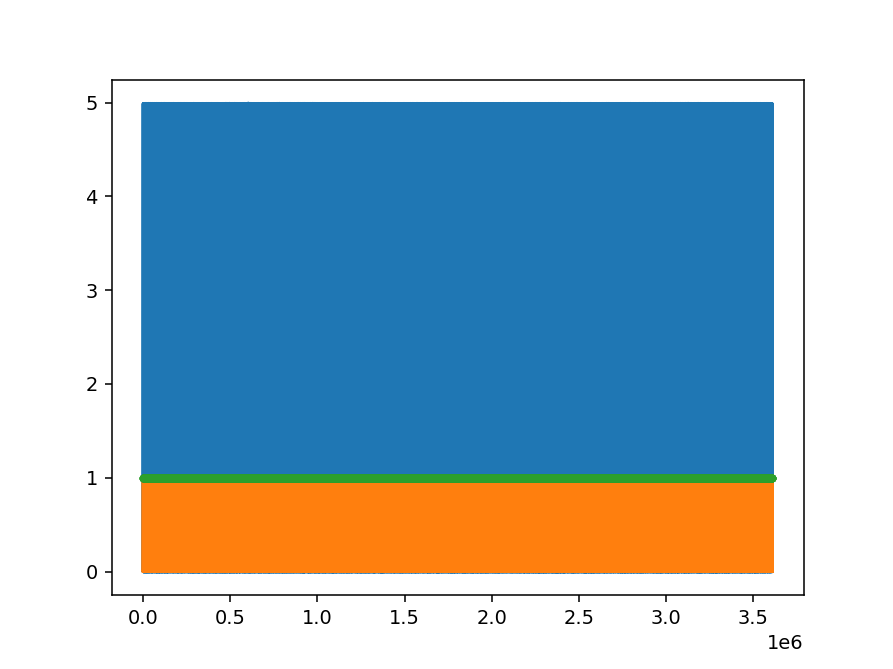

total elapsed time: 0.27 seconds


In [20]:
## Get camera signal times in ws ind

# Outputs:
# - ws_camSignal_bool_wsTime
# - ws_camSignal_times

tic = time.time()
ws_camSignal_bool_wsTime = np.abs(np.hstack(([0] , np.diff(ws_data[0,:])))) > 1

ws_camSignal_wsTimes = np.where(ws_camSignal_bool_wsTime)[0]

plt.figure()
plt.plot(ws_data[0,:]);
plt.plot(ws_camSignal_bool_wsTime);
plt.plot(ws_camSignal_wsTimes, np.ones(len(ws_camSignal_wsTimes)).T ,'.');
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


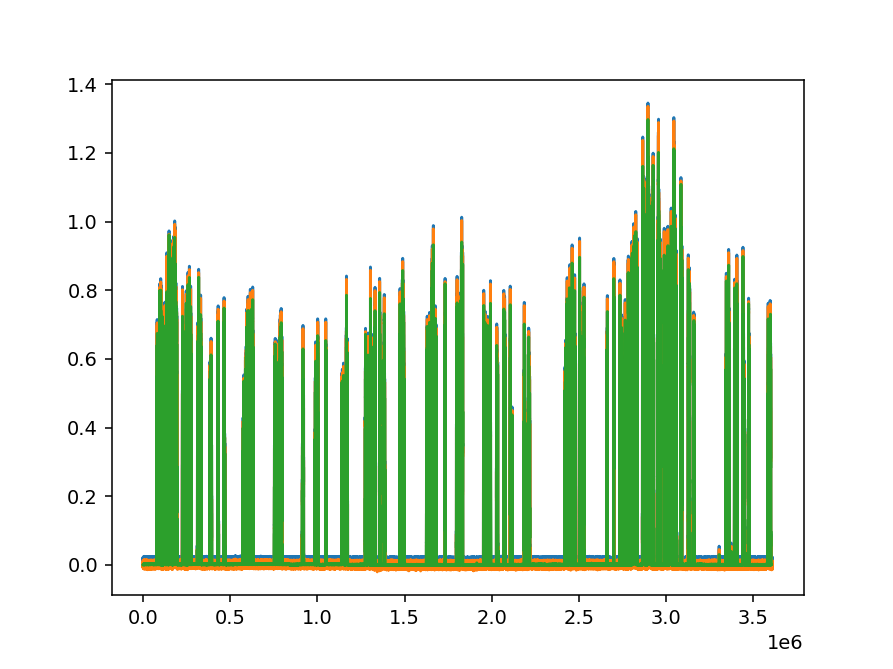

total elapsed time: 0.87 seconds


In [21]:
## Convert treadmill signal to S2p ind

# Outputs:
# - ws_treadmill_wsTime
# - ws_treadmill_S2pInd   ***

tic = time.time()
ws_treadmill_wsTime = ws_data[2,:] - np.percentile(ws_data[2,:], 20)

ws_treadmill_S2pInd = np.zeros(num_frames_S2p)
for frame_num, frame_ind in enumerate(ws_frameTimes_wsTime[0:]):
    if frame_num==0:
        continue
    ws_treadmill_S2pInd[frame_num] = sum(ws_treadmill_wsTime[ws_frameTimes_wsTime[frame_num-1] : ws_frameTimes_wsTime[frame_num]])
ws_treadmill_S2pInd = ws_treadmill_S2pInd / ws_samples_per_S2p_frame_rough

plt.figure()
plt.plot(ws_data[2,:])
plt.plot(ws_treadmill_wsTime)
plt.plot(ws_frameTimes_wsTime, ws_treadmill_S2pInd)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

<IPython.core.display.Javascript object>


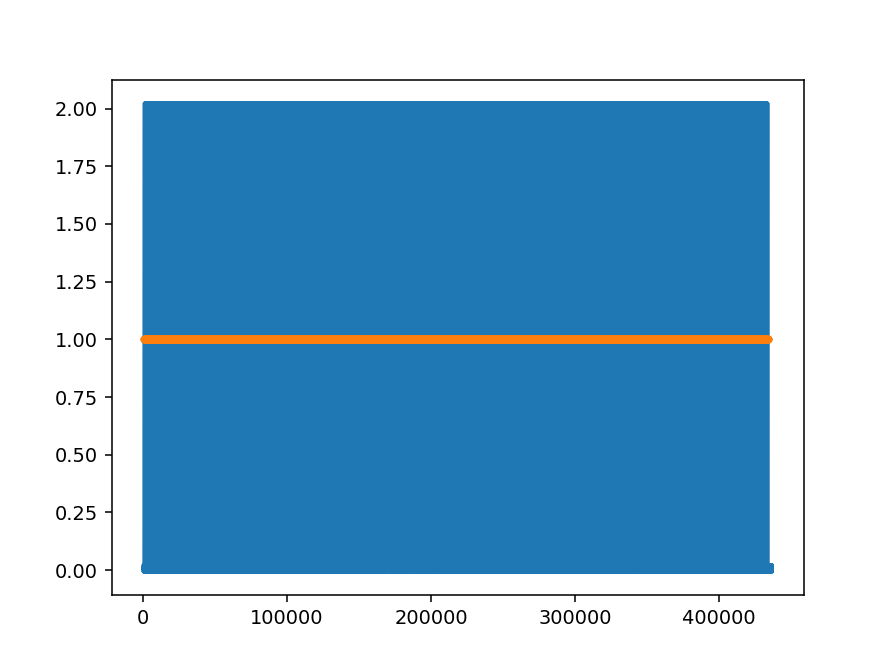

In [22]:
## Get camera signal times in ws ind

# Outputs:
# - ws_camSignal_bool_wsTime
# - camera_camSignal_camTimes
# - camera_frames_wsTime ***

# signal_GPIO[116801] = 241

tic = time.time()
input_signal_GPIO = scipy.stats.zscore(np.double(signal_GPIO))

signal_GPIO_bool_camTime = np.abs(np.hstack(([0] , np.diff(input_signal_GPIO)))) > 1
# plt.figure()
# plt.plot(signal_GPIO_bool_camTime)

signal_GPIO_camTimes = np.where(signal_GPIO_bool_camTime)[0]

plt.figure()
plt.plot(input_signal_GPIO+1);
# plt.plot(camera_camSignal_bool_camTime);
# plt.plot(np.diff(pixels_topLeft[:,8]));
plt.plot(signal_GPIO_camTimes, np.ones(len(signal_GPIO_camTimes)).T ,'.');

In [23]:
factors_temporal.shape
signal_GPIO.shape

(436940,)

In [24]:
print(ws_camSignal_wsTimes.shape)
print(signal_GPIO_camTimes.shape)

(7220,)
(7220,)


<IPython.core.display.Javascript object>


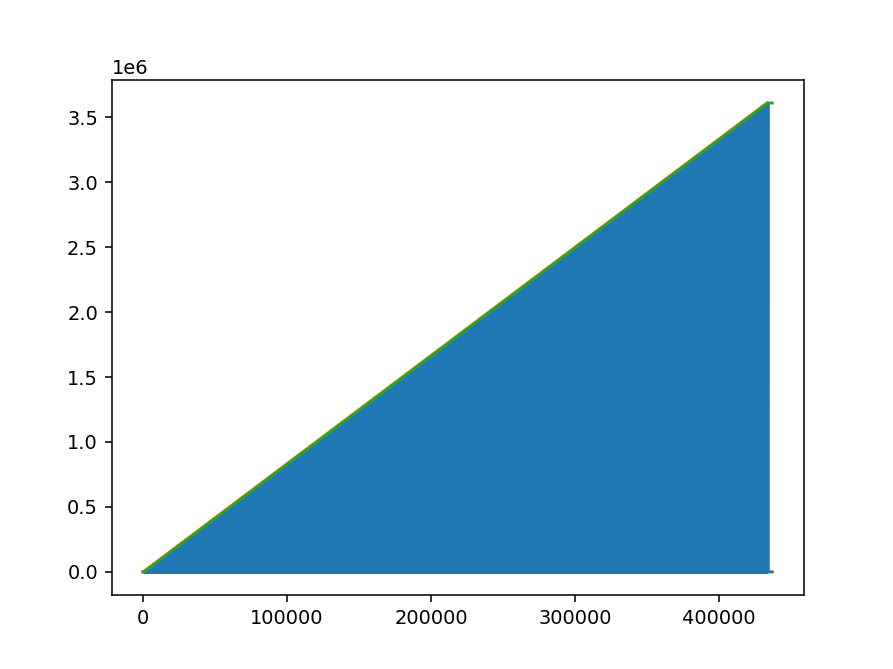

<IPython.core.display.Javascript object>


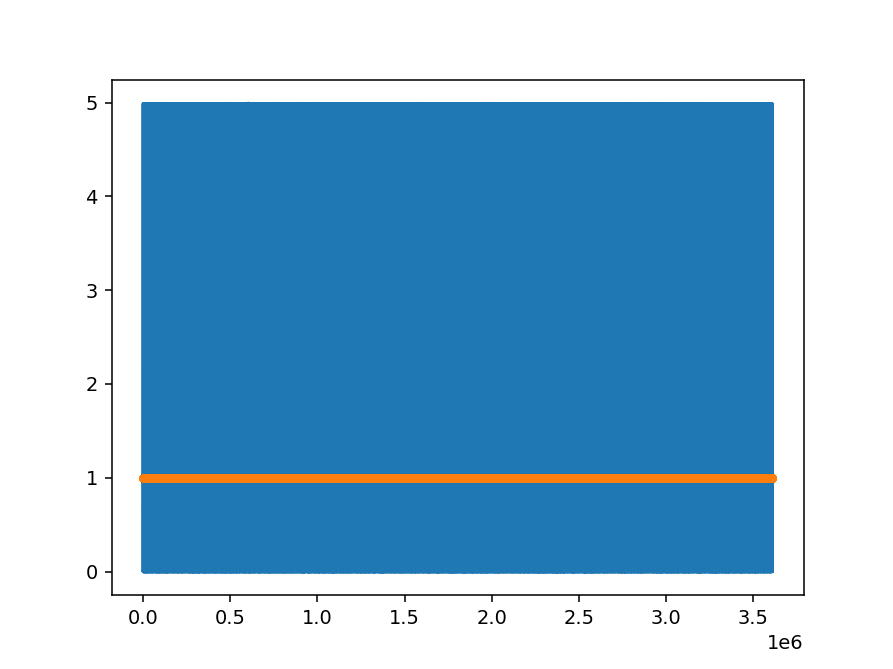

total elapsed time: 4.44 seconds


In [25]:
signal_GPIO_wsTimes = np.double(signal_GPIO_bool_camTime)
signal_GPIO_wsTimes[signal_GPIO_camTimes] = ws_camSignal_wsTimes
# signal_GPIO_wsTimes[signal_GPIO_camTimes] = crop_ws_camSignal_wsTimes
# plt.figure()
# plt.plot(signal_GPIO_wsTimes)

tmp = copy.deepcopy(signal_GPIO_wsTimes)
tmp[tmp==0] = np.nan
tmp = pd.DataFrame(tmp)
camera_frames_wsTimes = np.array(tmp.interpolate())
# plt.figure()
# plt.plot(camera_frames_wsTimes) 

tmp = copy.deepcopy(camera_frames_wsTimes)
tmp[np.isnan(tmp)] = 0
camera_frames_wsTimes_withLeadingZeros = np.int32(np.round(tmp))[:,0]
first_camFrame_camIdx = np.argmax(np.where(camera_frames_wsTimes_withLeadingZeros==0))+1
last_camFrame_camIdx = np.min(np.array(np.where(camera_frames_wsTimes_withLeadingZeros == np.max(camera_frames_wsTimes_withLeadingZeros))[0]))
camera_frames_wsTimes = camera_frames_wsTimes_withLeadingZeros[first_camFrame_camIdx:last_camFrame_camIdx]

plt.figure()
plt.plot(signal_GPIO_wsTimes)
plt.plot(camera_frames_wsTimes)
plt.plot(camera_frames_wsTimes_withLeadingZeros)

plt.figure()
plt.plot(ws_data[0,:])
plt.plot(camera_frames_wsTimes_withLeadingZeros , np.ones_like(camera_frames_wsTimes_withLeadingZeros) , '.')
# plt.plot(camera_frames_wsTimes , np.ones_like(camera_frames_wsTimes) , '.')
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

In [26]:
helpers.dump_nwb(nwb_path)

CQT
     Sxx_allPixels:    (1397, 35, 27309, 2)   ,  float32
     Sxx_allPixels_norm:    (1397, 35, 27309, 2)   ,  float32
     Sxx_allPixels_normFactor:    (27309, 2)   ,  float32
Optic Flow
     displacements:    (2483, 2, 436940)   ,  float64
     positions:    (2483, 2, 436940)   ,  float64
     positions_absolute:    (2483, 2, 436940)   ,  float64
     positions_convDR_absolute:    (1397, 2, 436940)   ,  float64
     positions_convDR_meanSub:    (1397, 2, 436940)   ,  float64
     positions_recursive:    (2483, 2, 436940)   ,  float64
TCA
     factors_spectral_points:    (2794, 8)   ,  float32
     factors_spectral_spectral:    (35, 8)   ,  float32
     factors_spectral_temporal:    (27309, 8)   ,  float32
     factors_spectral_temporal_interp:    (436939, 8)   ,  float64


<IPython.core.display.Javascript object>


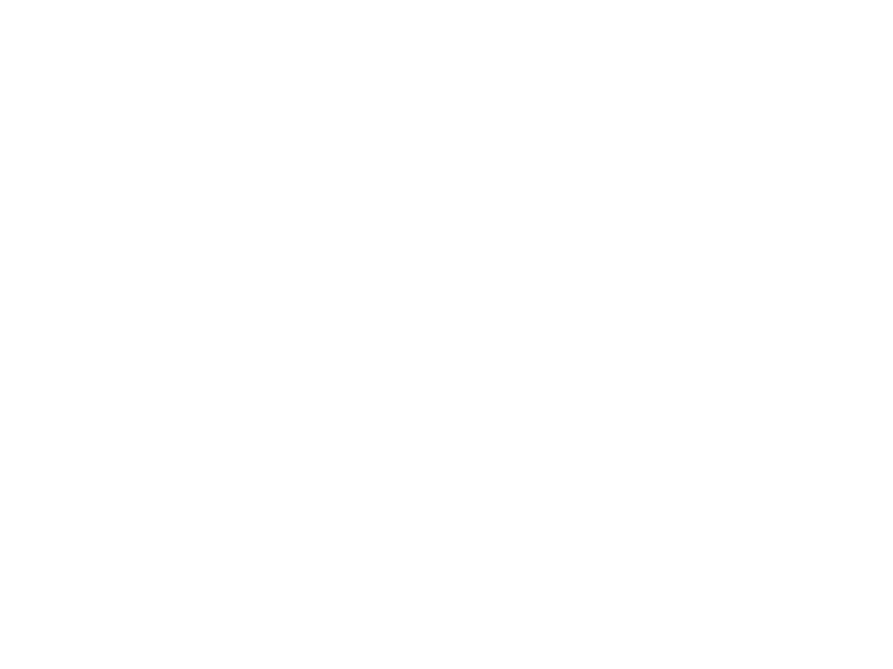

In [27]:
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()

    Sxx_faceRhythm = np.array(nwbfile.processing['Face Rhythm']['CQT']['Sxx_allPixels_norm'].data)

    %matplotlib notebook
    plt.figure()
    plt.plot(Sxx_faceRhythm[0,0,:,0])

<IPython.core.display.Javascript object>


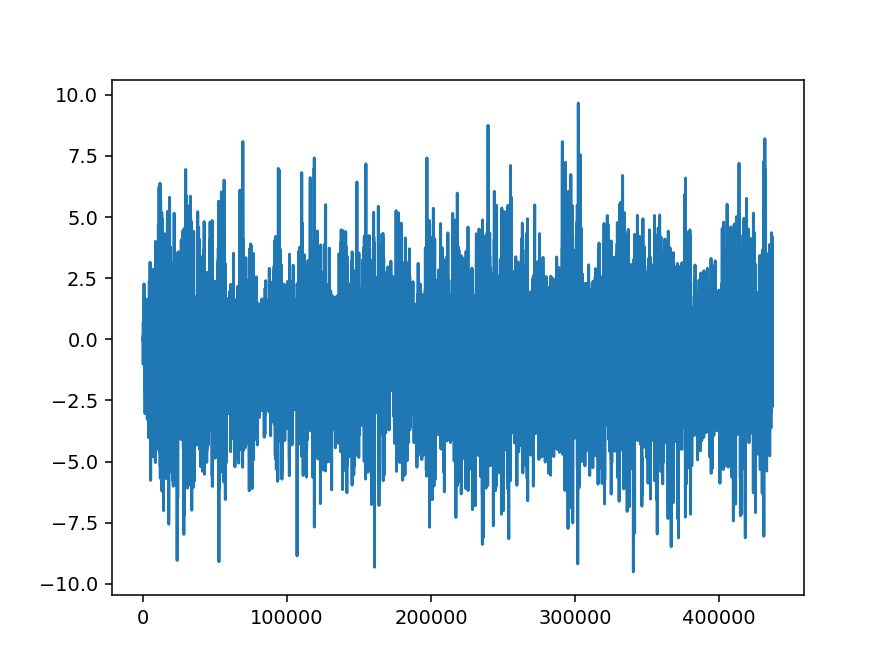

In [29]:
with pynwb.NWBHDF5IO(nwb_path, 'r') as io:
    nwbfile = io.read()

    positions_convDR_meanSub_faceRhythm = np.array(nwbfile.processing['Face Rhythm']['Optic Flow']['positions_convDR_meanSub'].data)

    %matplotlib notebook
    plt.figure()
    plt.plot(positions_convDR_meanSub_faceRhythm[0,0,:])

### resample the Sxx tensor into S2p indices
 1. Find the corresponding indices of the downsampled Face Factors (FFs) in the original camera's indices
 2. Find the wavesurfer indices of the FFs
  a. also remove duplicate indices and hold on to which FF indices must be removed for later
 3. Find the wavesurfer indices of S2p frames, and downsample the number of S2p frames you want to use
 4. Interpolate the FFs from cam frame indices to S2p indices, all within wavesurfer temporal space
  a. remember to not include the duplicate indices
 5. \
  a. Clip non-negative values\
  b. Depricate the array into a more compressed data type (like float16)\
  c. Make an x_axis for converting between S2p and output

In [33]:
# RESAMPLE: Sxx_faceRhythm

input_array = Sxx_faceRhythm

dim_temp = 2 # temporal dimension of Sxx
downsample_factor = 4 # amount to downsample the face factors after upsampling into s2p indices

upsample_factor = signal_GPIO.shape[0] / input_array.shape[dim_temp] # ratio between number of camera frames and number of FF frames
num_s2pFrames = len(ws_frameTimes_wsTime)

#1
FFtemporalIdx_camFrameIdx = np.int64(np.round(np.linspace(upsample_factor , len(signal_GPIO) , Sxx_faceRhythm.shape[dim_temp] ))) -1 # These are the corresponding camera frame numbers for each FF frame
#2
current_xAxis = camera_frames_wsTimes_withLeadingZeros[FFtemporalIdx_camFrameIdx] # camera frame ws indices of downsampled FF frames
#2a
out1, idx_nonDup = np.unique(current_xAxis, return_index=True, return_inverse=False, return_counts=False)
#3
downsampled_S2pIdx = np.arange(0,num_s2pFrames , downsample_factor)
new_xAxis = ws_frameTimes_wsTime[downsampled_S2pIdx] # ws idx of s2p frames, down(sub)sampled
#4
function_interp = scipy.interpolate.interp1d(
    current_xAxis[idx_nonDup] , 
    np.array(input_array).swapaxes(0,dim_temp)[idx_nonDup,...].swapaxes(0,dim_temp), 
    kind='cubic' , axis=dim_temp)
output_array = function_interp(new_xAxis)
#5
output_array = np.clip(output_array, 0 , None)
output_array = np.array(output_array, dtype='float32')

print(f'size of output array: {round(sys.getsizeof(output_array)/1000000000 , 3)} GB')
print(f'shape of input array: {input_array.shape}')
print(f'shape of output array: {output_array.shape}')

Sxx_s2pResamp = copy.deepcopy(output_array)
xAxisConversion_SxxToS2p = downsampled_S2pIdx

size of output array: 10.932 GB
shape of input array: (1446, 35, 27273, 2)
shape of output array: (1446, 35, 27000, 2)


In [34]:
# RESAMPLE: factors_temporal

input_array = factors_temporal

dim_temp = 0 # temporal dimension of Sxx
downsample_factor = 1 # amount to downsample the face factors after upsampling into s2p indices

upsample_factor = signal_GPIO.shape[0] / input_array.shape[dim_temp] # ratio between number of camera frames and number of FF frames
num_s2pFrames = len(ws_frameTimes_wsTime)

#1
FFtemporalIdx_camFrameIdx = np.int64(np.round(np.linspace(upsample_factor , len(signal_GPIO) , input_array.shape[dim_temp] ))) -1 # These are the corresponding camera frame numbers for each FF frame
#2
current_xAxis = camera_frames_wsTimes_withLeadingZeros[FFtemporalIdx_camFrameIdx] # camera frame ws indices of downsampled FF frames
#2a
out1, idx_nonDup = np.unique(current_xAxis, return_index=True, return_inverse=False, return_counts=False)
#3
downsampled_S2pIdx = np.arange(0,num_s2pFrames , downsample_factor)
new_xAxis = ws_frameTimes_wsTime[downsampled_S2pIdx] # ws idx of s2p frames, down(sub)sampled
#4
function_interp = scipy.interpolate.interp1d(
    current_xAxis[idx_nonDup] , 
    np.array(input_array).swapaxes(0,dim_temp)[idx_nonDup,...].swapaxes(0,dim_temp), 
    kind='cubic' , axis=dim_temp)
output_array = function_interp(new_xAxis)
#5
output_array = np.clip(output_array, 0 , None)
output_array = np.array(output_array, dtype='float32')

print(f'size of output array: {round(sys.getsizeof(output_array)/1000000000 , 3)} GB')
print(f'shape of input array: {input_array.shape}')
print(f'shape of output array: {output_array.shape}')

temporalFactors_resamp = copy.deepcopy(output_array)
xAxisConversion_factorsTemporalToS2p = downsampled_S2pIdx

size of output array: 0.003 GB
shape of input array: (27273, 8)
shape of output array: (108000, 8)


### resample the Positions tensor into S2p indices
 1. Find the corresponding indices of the downsampled Face Factors (FFs) in the original camera's indices (same as above)
 2. Find the wavesurfer indices of the FFs (same as above)\
  a. also remove duplicate indices and hold on to which FF indices must be removed for later
 3. Find the wavesurfer indices of S2p frames, and ***UPSAMPLE*** the number of S2p frames **to a similar number frame rate as the camera** ***DIFFERENT FROM ABOVE***
  a. The new axis in the interpolation is weird. To upsample between two points properly with a given spacing, you have to extrapolate off one of the ends. I extrapolate the extra samples at the beginning by just concatenating zeros to it
 4. Interpolate the FFs from cam frame indices to S2p indices, all within wavesurfer temporal space (same as above)\
  a. remember to not include the duplicate indices
 5. \
  a. Depricate the array into a more compressed data type (like float16)\
  b. Make an x_axis for converting between S2p and output

In [30]:
# RESAMPLE: positions_convDR_meanSub_faceRhythm

input_array = positions_convDR_meanSub_faceRhythm

dim_temp = 2 # temporal dimension of Sxx
downsample_factor = 0.25 # amount to downsample the face factors after upsampling into s2p indices. Fractional numbers results in upsampling

upsample_factor = signal_GPIO.shape[0] / input_array.shape[dim_temp] # ratio between number of camera frames and number of FF frames
num_s2pFrames = len(ws_frameTimes_wsTime)

#1
FFtemporalIdx_camFrameIdx = np.int64(np.round(np.linspace(upsample_factor , len(signal_GPIO) , input_array.shape[dim_temp] ))) -1 # These are the corresponding camera frame numbers for each FF frame
#2
current_xAxis = camera_frames_wsTimes_withLeadingZeros[FFtemporalIdx_camFrameIdx] # camera frame ws indices of downsampled FF frames
#2a
out1, idx_nonDup = np.unique(current_xAxis, return_index=True, return_inverse=False, return_counts=False)
#3
function_interp = scipy.interpolate.interp1d( np.array(np.arange(0, len(ws_frameTimes_wsTime)) , 'float64') , ws_frameTimes_wsTime)
upsampled_S2pIdx = np.concatenate(( np.zeros(int((1/downsample_factor) -1)) , np.arange(0, len(ws_frameTimes_wsTime)-1+downsample_factor, downsample_factor) ))
upsampled_S2pFrameIdx_wsTime = function_interp( upsampled_S2pIdx )
new_xAxis = upsampled_S2pFrameIdx_wsTime
#4
function_interp = scipy.interpolate.interp1d(
    current_xAxis[idx_nonDup] , 
    np.array(input_array).swapaxes(0,dim_temp)[idx_nonDup,...].swapaxes(0,dim_temp), 
    kind='cubic' , axis=dim_temp)
output_array = function_interp(new_xAxis)
#5
output_array = np.array(output_array, dtype='float32')

print(f'size of output array: {round(sys.getsizeof(output_array)/1000000000 , 3)} GB')
print(f'shape of input array: {input_array.shape}')
print(f'shape of output array: {output_array.shape}')

positions_convDR_meanSub_faceRhythm_resamp = copy.deepcopy(output_array)
xAxisConversion_cameraToS2p = upsampled_S2pIdx

size of output array: 4.828 GB
shape of input array: (1397, 2, 436940)
shape of output array: (1397, 2, 432000)


In [31]:
dir_save = r'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 11.5/20210113/cam1/forAlex_20210113/behavior'

In [38]:
name_save = 'Sxx_s2pResamp'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , Sxx_s2pResamp)

In [39]:
name_save = 'xAxisConversion_SxxToS2p'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , xAxisConversion_SxxToS2p)

In [40]:
name_save = 'temporalFactors_resamp'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , temporalFactors_resamp)

In [41]:
name_save = 'xAxisConversion_factorsTemporalToS2p'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , xAxisConversion_factorsTemporalToS2p)

In [32]:
name_save = 'positions_convDR_meanSub_faceRhythm_resamp'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , positions_convDR_meanSub_faceRhythm_resamp)

In [33]:
name_save = 'xAxisConversion_cameraToS2p'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , xAxisConversion_cameraToS2p)

In [44]:
name_save = 'ws_licks_bool_S2pInd'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , ws_licks_bool_S2pInd)

In [45]:
name_save = 'ws_treadmill_S2pInd'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , ws_treadmill_S2pInd)

In [46]:
name_save = 'ws_rewards_bool_S2pInd'
path_save = f'{dir_save}{slash_type}{name_save}'

np.save(path_save , ws_rewards_bool_S2pInd)

In [47]:
### Make dFoF and zscored stuff
tic = time.time()
# F_neuSub = F - 0.7*Fneu
# F_baseline_static = np.percentile(F_neuSub,30)
# dF = F_neuSub - F_baseline_static
# dFoF = dF / F_baseline_static

F_zscore = scipy.stats.zscore(F, axis=1)
# spks_zscore = scipy.stats.zscore(spks, axis=1)
print(f'total elapsed time: {round(time.time() - tic,2)} seconds')

total elapsed time: 2.46 seconds


In [48]:
## Make rolling baseline subtraction
import welford_moving_2D
import tqdm
from tqdm import trange

# list_of_values = [3, 5, 8, 10, 4, 8, 12, 15, 11, 9]
F_mean_rolling = np.ones_like(F.T) * np.nan
F_var_rolling = np.ones_like(F.T) * np.nan
win_size_rollingBaseline = round(30 * 60*20)
list_of_values = F.T
varSum_old = None
mean_old = None
for idx in trange(len(list_of_values)):

    mean_new = welford_moving_2D.update_mean(idx, list_of_values, win_size_rollingBaseline, mean_old)
    varSum_new = welford_moving_2D.update_varSum(idx, list_of_values, win_size_rollingBaseline, varSum_old)
    var_new = welford_moving_2D.varSum_to_var(idx, list_of_values, win_size_rollingBaseline, mean_new, varSum_new)

    F_mean_rolling[idx,:] = mean_new
    F_var_rolling[idx,:] = var_new
#     msg = "SMA=%.4f, PSA=%.4f, Var=%.4f" % (mean_new, varSum_new, var_new)
#     print("bar %i: %s" % (idx, msg))

    mean_old = mean_new
    varSum_old = varSum_new

eps = 1e-7
F_var_rolling[F_var_rolling<eps] = eps
F_zscore_roll = (list_of_values - F_mean_rolling)/np.sqrt(F_var_rolling)

  8%|▊         | 8196/108000 [00:04<00:52, 1890.26it/s]


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


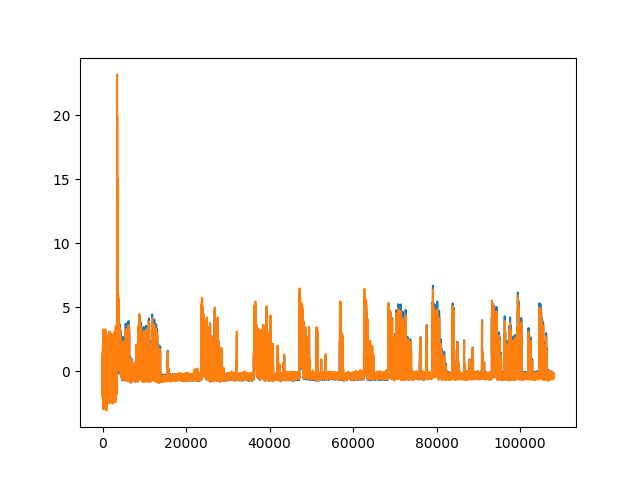

In [47]:
roi_toShow = 0
plt.figure()
plt.plot(F_zscore[roi_toShow,:])
plt.plot(F_zscore_roll[:,roi_toShow])

In [44]:
## == REGRESSION ANALYSIS

In [49]:
# input_dimRed = F_zscore_roll[:,IsCell_ROIClassifier==True]
input_dimRed = F_zscore_roll[:,iscell[:,0]==True]
n_components = input_dimRed.shape[1]
pca = sk.decomposition.PCA(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
pca.fit(np.single(input_dimRed).transpose())
output_PCA = pca.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

output_PCA.shape
plt.figure()
plt.plot(pca.explained_variance_ratio_)

NameError: name 'F_zscore_roll' is not defined

In [50]:
## Check alignment between S2p and face data before running

input_dimRed = spks[iscell[:,0]==1,:].T
input_dimRed = scipy.signal.savgol_filter( input_dimRed , 41 , 3 , axis=0)
input_dimRed[input_dimRed < 0] = 0

# input_dimRed = F_zscore_roll[:,iscell[:,0]==True]
# input_dimRed = F_zscore[iscell[:,0]==True , :].T
n_components = temporalFactors_resamp.shape[1]
fa = sk.decomposition.NMF(n_components=n_components)
# pca = sk.decomposition.FactorAnalysis(n_components=3)
fa.fit(np.single(input_dimRed).transpose())
output_fa = fa.components_.transpose()
# scores_points = np.dot(ensemble.factors(4)[0][2] , output_PCA)

<IPython.core.display.Javascript object>


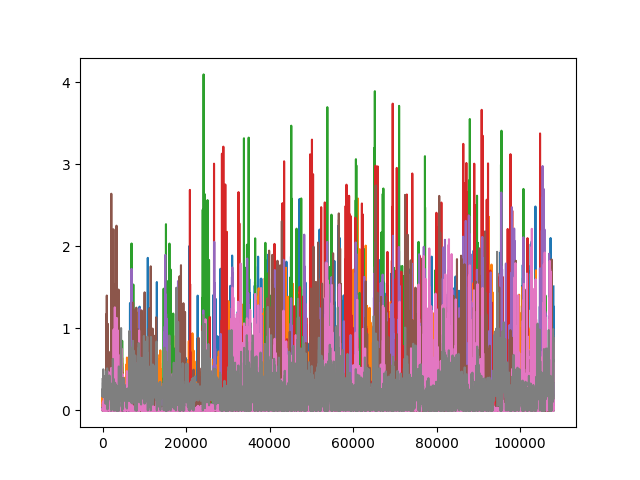

In [51]:
plt.figure()
plt.plot(output_fa);

<IPython.core.display.Javascript object>


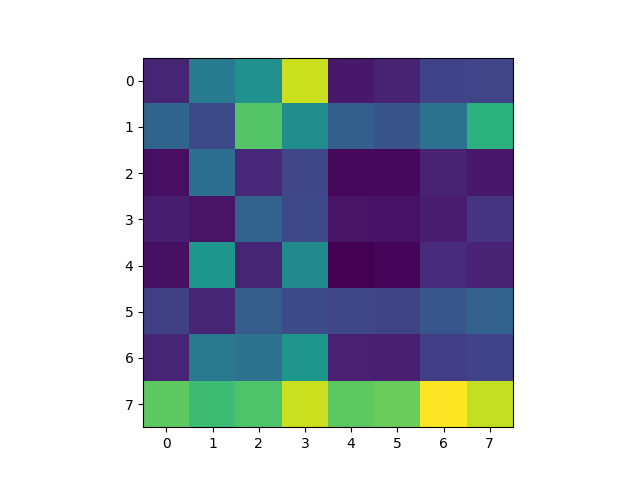

<IPython.core.display.Javascript object>


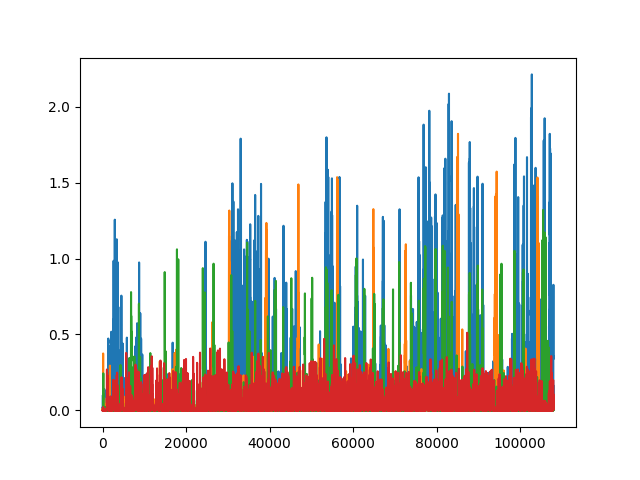

In [52]:
stds = np.meshgrid(np.std(output_fa , axis=0) , np.std(temporalFactors_resamp , axis=0))
std_prod = stds[0]*stds[1]

plt.figure()
plt.imshow((output_fa.T @ temporalFactors_resamp)/std_prod.T )
# plt.imshow(np.corrcoef(output_fa , temporalFactors_resamp))

plt.figure()
plt.plot(output_fa[:,6])
plt.plot((temporalFactors_resamp[:,:3]**2) /10)

<IPython.core.display.Javascript object>


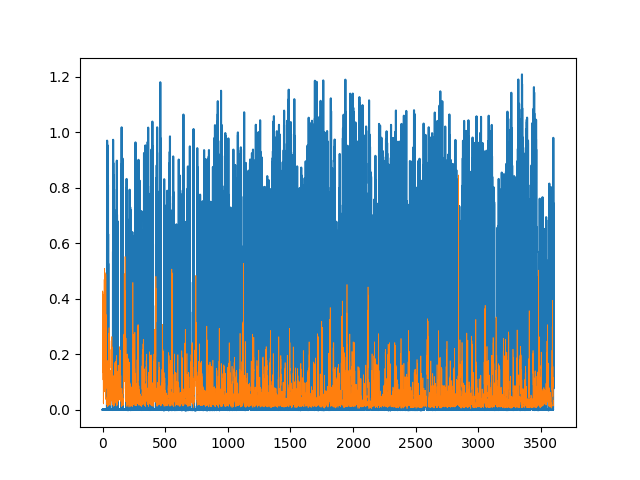

In [53]:
downsample_factor = 4
plt.figure()
plt.plot(np.arange(len(ws_treadmill_S2pInd))/30 , ws_treadmill_S2pInd)
plt.plot(((np.arange(Sxx_s2pResamp.shape[2])*downsample_factor)/30) , np.mean(Sxx_s2pResamp[600,28:,:,0] , axis=0) *10 , linewidth=-.5)
# plt.plot(((np.arange(factors_temporal.shape[0])*downsample_factor)/30) , (factors_temporal[:,7]**2)/10 , linewidth=1)

In [55]:
# import sklearn.linear_model
# from catboost import CatBoostRegressor


# num_factors = temporalFactors_s2pInd.shape[1]
num_factors = 8

# idx_nonRunning = np.where(ws_treadmill_S2pInd[75000:] < 0.005)[0]
# idx_nonRunning = np.where(ws_treadmill_S2pInd[np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))] < 0.005)[0]
# idx_nonRunning = ws_treadmill_S2pInd < 0.005
# idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0
# idx_nonRunning = np.where(idx_nonRunning[tmp])[0]
# idx_nonRunning = np.where(idx_nonRunning[~np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))])[0]

# X_input = dFoF[IsCell_ROIClassifier==True,:].T
# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = F_zscore_roll[:,iscell[:,0]==1]
# X_input = F_zscore[iscell[:,1]>0.05,:].T
# X_input = F_zscore_roll
# X_input = F_zscore[iscell[:,0]==1,:].T
X_input = spks[iscell[:,0]==1,:].T
X_input = scipy.signal.savgol_filter( X_input , 41 , 3 , axis=0)
# X_input = spks[iscell[:,0],:]
# X_input = X_input[idx_nonRunning,:]
# X_input = dFoF.T
# X_input = output_PCA[:,np.array([0,1,1000])]
# X_input = output_PCA[:,:]
# y_input = temporalFactors_s2pInd
# y_input = scipy.signal.savgol_filter( temporalFactors_s2pInd[idx_nonRunning,:] , 21 , 3 , axis=0 )
# y_input = temporalFactors_s2pInd[idx_nonRunning,:] 
# y_input = temporalFactors_s2pInd
y_input = scipy.signal.resample(temporalFactors_resamp, X_input.shape[0])
# y_input[y_input<0] = 0
# y_input = y_input**(1/3)
# y_input = ws_licks_bool_S2pInd

# X = np.hstack((np.ones(spks.shape[1]).reshape(spks.shape[1],1) ,
#                np.linspace(0,1,spks.shape[1])[:,None],
#                X_input))
# X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))

# y_reconstructed_FF = np.zeros((X.shape[0] , num_factors))
y_reconstructed_FF = np.zeros((X_input.shape[0] , num_factors))
y = np.zeros((X.shape[0] , num_factors))
R = np.zeros((num_factors))
theta_FF = np.ones((X_input.shape[1]+1,num_factors))
for iter_factor in range(num_factors):
# for iter_factor in np.array([5]):

#     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor] ** (1/2)
#     y[:,iter_factor] = temporalFactors_s2pInd[:,iter_factor]
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3)) ** (1/2)
    y[:,iter_factor] = y_input[:,iter_factor]
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input[:,iter_factor] , 21 , 3))
#     y[:,iter_factor] = abs(scipy.signal.savgol_filter(y_input , 101 , 3)) ** (1/2)
#     y[:,iter_factor] = abs(y_input) ** (1/2)

    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
        X, y[:,iter_factor], test_size=0.3, random_state=0)
    
    ### SKLEARN regression
# #     clf = sklearn.linear_model.Lasso(alpha=1e-1)
#     clf = sklearn.linear_model.LinearRegression()
#     clf.fit(X_train , y_train )
#     theta_FF[:,iter_factor] = clf.coef_

#     ### CATBOOST regression
#     model = CatBoostRegressor(iterations=2000,
# #                               learning_rate=1,
# #                               depth=2,
#                               task_type="GPU",
#                               devices='0:1')
#     model.fit(X_train, y_train)
#     y_train_output = model.predict(X_train)
#     y_test_output = model.predict(X_test)

    theta_FF[:,iter_factor] = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

    y_train_output = X_train @ theta_FF[:,iter_factor]
    R_train = (np.corrcoef(y_train_output, y_train))[1,0]
    print(f'iter: {iter_factor} , train R: {R_train}')
    
    y_test_output = X_test @ theta_FF[:,iter_factor]
    R[iter_factor] = (np.corrcoef(y_test_output, y_test))[1,0]
    print(f'iter: {iter_factor} , test  R: {R[iter_factor]} , test  R^2: {R[iter_factor]**2}')
    
#     y_reconstructed[:,iter_factor] = X @ theta_FF[:,iter_factor]
#     y_reconstructed_FF[:,iter_factor] = np.hstack((np.ones(F_zscore_roll.shape[0]).reshape(F_zscore_roll.shape[0],1) , F_zscore_roll[:,IsCell_ROIClassifier==True])) @ theta_FF[:,iter_factor]
    y_reconstructed_FF[:,iter_factor] = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input)) @ theta_FF[:,iter_factor]

iter: 0 , train R: 0.7689784635611046
iter: 0 , test  R: 0.7650299165913872 , test  R^2: 0.5852707732798248
iter: 1 , train R: 0.8594809549832345
iter: 1 , test  R: 0.8533992449035485 , test  R^2: 0.7282902712019467
iter: 2 , train R: 0.8547759410617505
iter: 2 , test  R: 0.8514200039078266 , test  R^2: 0.7249160230544034
iter: 3 , train R: 0.8748965553237189
iter: 3 , test  R: 0.8721405861532749 , test  R^2: 0.760629202015778
iter: 4 , train R: 0.7817898968103613
iter: 4 , test  R: 0.7735204980199368 , test  R^2: 0.5983339608570111
iter: 5 , train R: 0.8151069775605897
iter: 5 , test  R: 0.8062180460599511 , test  R^2: 0.6499875377927253
iter: 6 , train R: 0.7706567400809665
iter: 6 , test  R: 0.7641551992935938 , test  R^2: 0.583933168607432
iter: 7 , train R: 0.6838720092283188
iter: 7 , test  R: 0.6749737497369016 , test  R^2: 0.45558956283389346


<IPython.core.display.Javascript object>


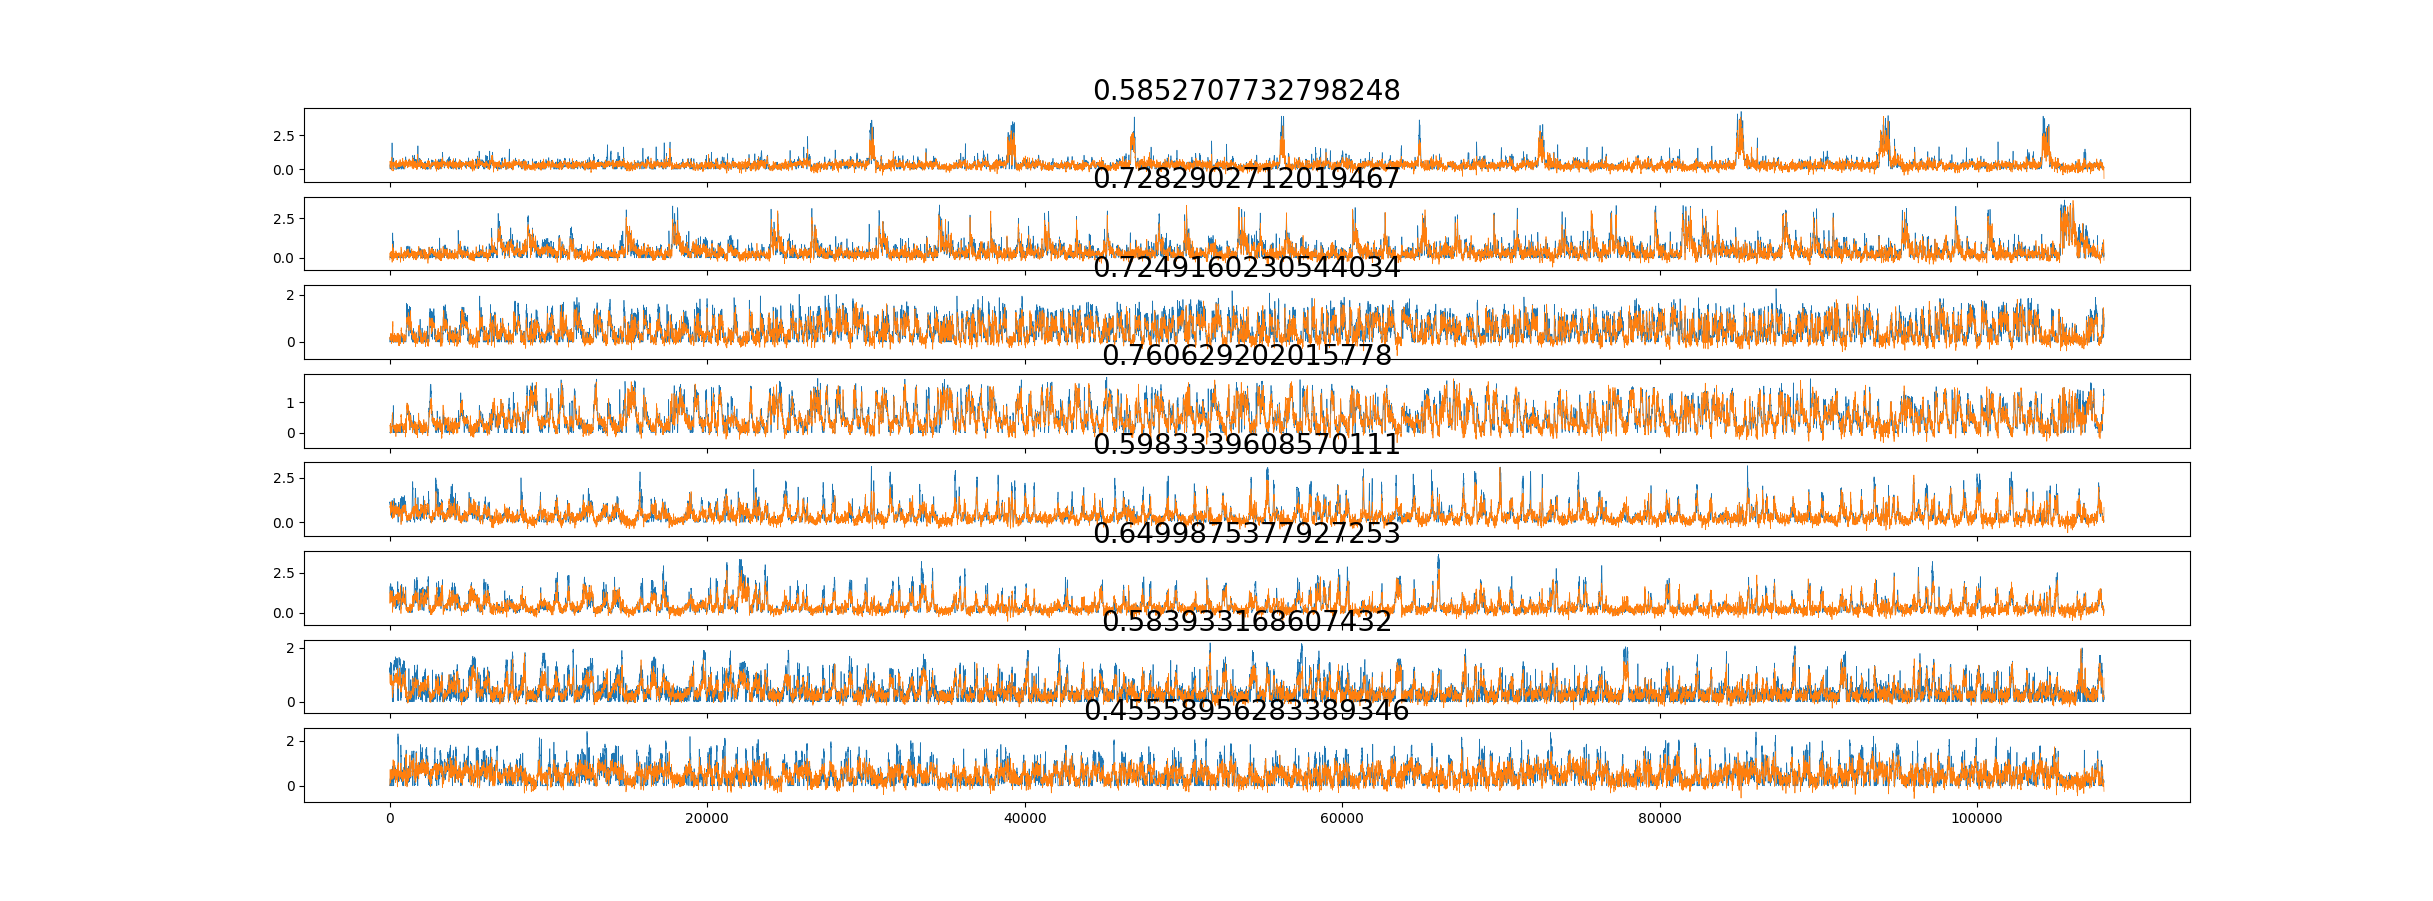

In [56]:
%matplotlib notebook
fig, axs = plt.subplots(num_factors, 1, sharex=True, sharey=False)
for iter_factor in range(num_factors):
#     plt.subplot(num_factors , 1, iter_factor+1)
#     subplot_size = int(str(num_factors) + str(1) + str(iter_factor+1))
#     axs = fig.add_subplot(subplot_size)
#     plt.plot(scipy.signal.savgol_filter( temporalFactors_s2pInd[:,iter_factor] ,21,3 ), linewidth=0.5)
    axs[iter_factor].plot(y_input[:,iter_factor] , linewidth=0.5)
##     plt.plot(y_reconstructed_FF[:,iter_factor] , linewidth=0.5)
    axs[iter_factor].plot(scipy.signal.savgol_filter( y_reconstructed_FF[:,iter_factor] ,5,3 ) , linewidth=0.5)
#     plt.plot(ws_treadmill_S2pInd / .2 , linewidth=1.0)
#     plt.plot(ws_licks_bool_S2pInd / .4 , linewidth=1.0)
    axs[iter_factor].set_title(R[iter_factor]**2, {'fontsize':20})

treadmill, train R: 0.856902158545294
treadmill, test  R: 0.852622015146523
R^2: 0.7269643007125177


<IPython.core.display.Javascript object>


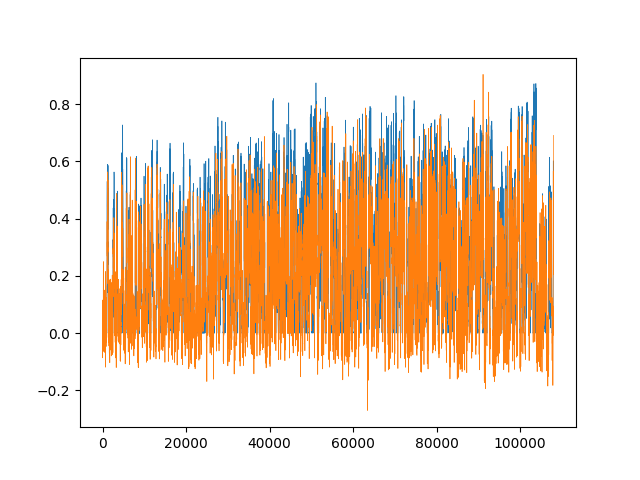

In [57]:
## Correlate to treadmill signal

# idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# # tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = F_zscore_roll
X_input = spks[iscell[:,0]==1,:].T
X_input = scipy.signal.savgol_filter( X_input , 31 , 3 , axis=0)
X_input[X_input<0] = 0
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
# y_input = ws_treadmill_S2pInd
# y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd[idx_nonRunning] , 31 , 3 )
y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd , 31 , 3 )
y_input[y_input<0] = 0

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
# plt.plot(y_reconstructed , linewidth=0.5)
plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)

treadmill, train R: 0.9141412293746032
treadmill, test  R: 0.9105606746225119
R^2: 0.829120742169004


<IPython.core.display.Javascript object>


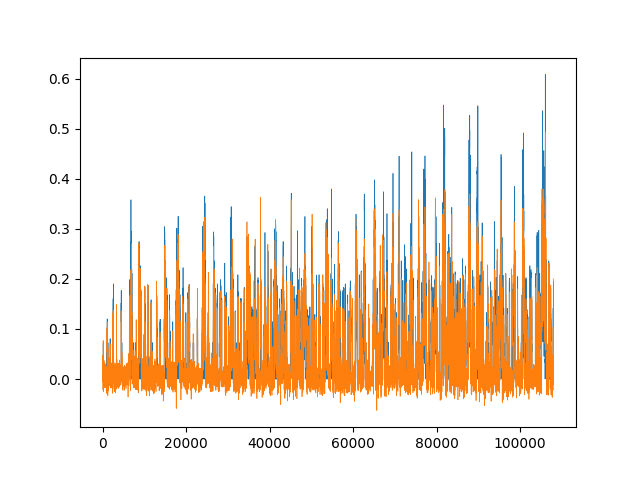

In [58]:
## Correlate to licking signal

# idx_nonRunning = np.ones_like(ws_treadmill_S2pInd)==1
# # tmp = np.concatenate((np.arange(20000,60000) , np.arange(75000,108000)))
# idx_nonRunning[:20000] = 0
# idx_nonRunning[60000:75000] = 0

# X_input = F_zscore_roll[:,IsCell_ROIClassifier==True]
# X_input = F_zscore_roll
X_input = spks[iscell[:,0]==1,:].T
X_input = scipy.signal.savgol_filter( X_input , 31 , 3 , axis=0)
X_input[X_input<0] = 0
# X_input = X_input[idx_nonRunning,:]
# y_input = ws_treadmill_S2pInd[75000:]
# y_input = scipy.signal.savgol_filter( ws_treadmill_S2pInd[idx_nonRunning] , 31 , 3 )
y_input = scipy.signal.savgol_filter( ws_licks_bool_S2pInd , 31 , 3 )
y_input[y_input<0] = 0

X = np.hstack((np.ones(X_input.shape[0]).reshape(X_input.shape[0],1) , X_input))
y = y_input

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0)

theta_treadmill = copy.deepcopy(np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train)

y_train_output = X_train @ theta_treadmill
R_train = (np.corrcoef(y_train_output, y_train))[1,0]
print(f'treadmill, train R: {R_train}')

y_test_output = X_test @ theta_treadmill
R = (np.corrcoef(y_test_output, y_test))[1,0]
print(f'treadmill, test  R: {R}')
print(f'R^2: {R**2}')

y_reconstructed = X @ theta_treadmill

plt.figure()
plt.plot(y_input , linewidth=0.5)
plt.plot(y_reconstructed , linewidth=0.5)
# plt.plot(scipy.signal.savgol_filter( y_reconstructed ,31,3 ) , linewidth=0.5)

In [195]:
## Saving output ensembles
import scipy.io

factor_toUse_oneIdxed = 5

weights_RegressionAnalysisOutput = theta_FF[1:,factor_toUse_oneIdxed-1]

regression_output = {"regression_goalSignal": temporalFactors_s2pInd[:,factor_toUse_oneIdxed-1],
                     "regression_reconstruction":y_reconstructed_FF[:,factor_toUse_oneIdxed-1]
                    }

weights_day0 = {
  "weights": weights_RegressionAnalysisOutput,
  "iscell_custom": IsCell_ROIClassifier,
    "win_size_rollingBaseline": win_size_rollingBaseline,
    "factor_toUse_oneIdxed": factor_toUse_oneIdxed,
    "regression_output":regression_output,
}

dir_save = r'/media/rich/bigSSD RH/res2p/scanimage data/round 4 experiments/mouse 11.5/20210112'
save_name = 'weights_day0'
save_fullPath = f'{dir_save}{slash_type}weights_day0'

F = scipy.io.savemat(f'{save_fullPath}.mat' , weights_day0)

np.save(f'{save_fullPath}.npy' , weights_day0)

<IPython.core.display.Javascript object>


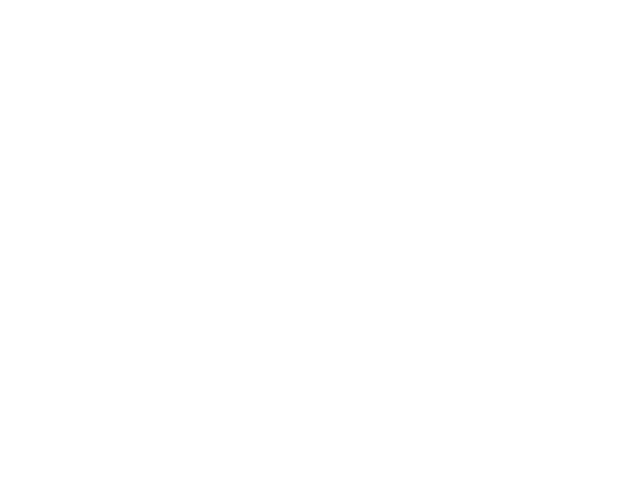

NameError: name 'weights_RegressionAnalysisOutput' is not defined

In [138]:
plt.figure()
plt.plot(weights_RegressionAnalysisOutput)
plt.plot(scipy.signal.savgol_filter(weights_RegressionAnalysisOutput , 101 , 3))